<a href="https://colab.research.google.com/github/veyselalevcan/Time_Series/blob/main/portugal_electiricity_consumption_lstm_time_series_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y tensorflow keras tensorflow-model-optimization
!pip install tensorflow==2.15.0
!pip install keras==3.0
!pip install tensorflow-model-optimization==0.8.0

Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
Found existing installation: keras 3.5.0
Uninstalling keras-3.5.0:
  Successfully uninstalled keras-3.5.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled m

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import timedelta
import tempfile
import os
import tensorflow as tf
import tf_keras as keras
from tf_keras import layers, models
import tensorflow_model_optimization as tfmot

In [ ]:
# **1. Data Loading and Preprocessing**
data = pd.read_csv('time_series_60min_singleindex.csv')

# Filter the electricity consumption data
data = data[['utc_timestamp', 'PT_load_actual_entsoe_transparency']].dropna()

# Convert timestamp to date format and set as index
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'])
data.set_index('utc_timestamp', inplace=True)

# Scale the consumption data
scaler = MinMaxScaler()
data['scaled_demand'] = scaler.fit_transform(data[['PT_load_actual_entsoe_transparency']])

data.head()


,PT_load_actual_entsoe_transparency,scaled_demand
utc_timestamp,,
2015-01-01 01:00:00+00:00,5123.9,0.345403
2015-01-01 02:00:00+00:00,4771.1,0.283420
2015-01-01 03:00:00+00:00,4443.5,0.225865
2015-01-01 04:00:00+00:00,4234.9,0.189216
2015-01-01 05:00:00+00:00,4118.2,0.168713


In [ ]:
# **2. Data Preparation for LSTM**
def create_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24  # Daily (24-hour) data segments
X, y = create_sequences(data['scaled_demand'].values, seq_length)

# Split data into training and test sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape input data for LSTM (3D format)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# 3. Define Model architecture for the initial (non-pruned) model
inputs = tf.keras.Input(shape=(seq_length, 1))
lstm = tf.keras.layers.LSTM(50, activation='relu')(inputs)
dense_output = tf.keras.layers.Dense(1)(lstm)
non_pruned_model = tf.keras.Model(inputs=inputs, outputs=dense_output)

# Compile initial model
non_pruned_model.compile(optimizer='adam', loss='mse')

# Train the initial model
non_pruned_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the non-pruned model
non_pruned_predicted = non_pruned_model.predict(X_test)
non_pruned_predicted_rescaled = scaler.inverse_transform(non_pruned_predicted)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/20
2517/2517 [==============================] - 49s 12ms/step - loss: 0.0045 - val_loss: 9.3996e-04
Epoch 2/20
2517/2517 [==============================] - 26s 10ms/step - loss: 0.0011 - val_loss: 8.3504e-04
Epoch 3/20
2517/2517 [==============================] - 35s 14ms/step - loss: 9.1351e-04 - val_loss: 8.8313e-04
Epoch 4/20
2517/2517 [==============================] - 25s 10ms/step - loss: 7.8403e-04 - val_loss: 8.8059e-04
Epoch 5/20
2517/2517 [==============================] - 28s 11ms/step - loss: 6.8893e-04 - val_loss: 5.1326e-04
Epoch 6/20
2517/2517 [==============================] - 29s 11ms/step - loss: 5.8214e-04 - val_loss: 4.7328e-04
Epoch 7/20
2517/2517 [==============================] - 29s 11ms/step - loss: 4.8507e-04 - val_loss: 3.7051e-04
Epoch 8/20
2517/2517 [==============================] - 28s 11ms/step - loss: 4.3637e-04 - val_loss: 4.8610e-04
Epoch 9/20
2517/2517 [==============================] - 28s 11ms/step - loss: 4.0416e-04 - val_loss: 4.2716e-04


In [ ]:
# 4. **Performance Analysis Before Pruning**
# Evaluate non-pruned model
non_pruned_predicted = non_pruned_model.predict(X_test)
non_pruned_predicted_rescaled = scaler.inverse_transform(non_pruned_predicted)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Performance evaluation metrics
non_pruned_mse = mean_squared_error(y_test_rescaled, non_pruned_predicted_rescaled)
non_pruned_mae = mean_absolute_error(y_test_rescaled, non_pruned_predicted_rescaled)

print(f"Mean Squared Error (MSE): {non_pruned_mse:.2f}")
print(f"Mean Absolute Error (MAE): {non_pruned_mae:.2f}")

315/315 [==============================] - 2s 5ms/step
Mean Squared Error (MSE): 7519.90
Mean Absolute Error (MAE): 62.46


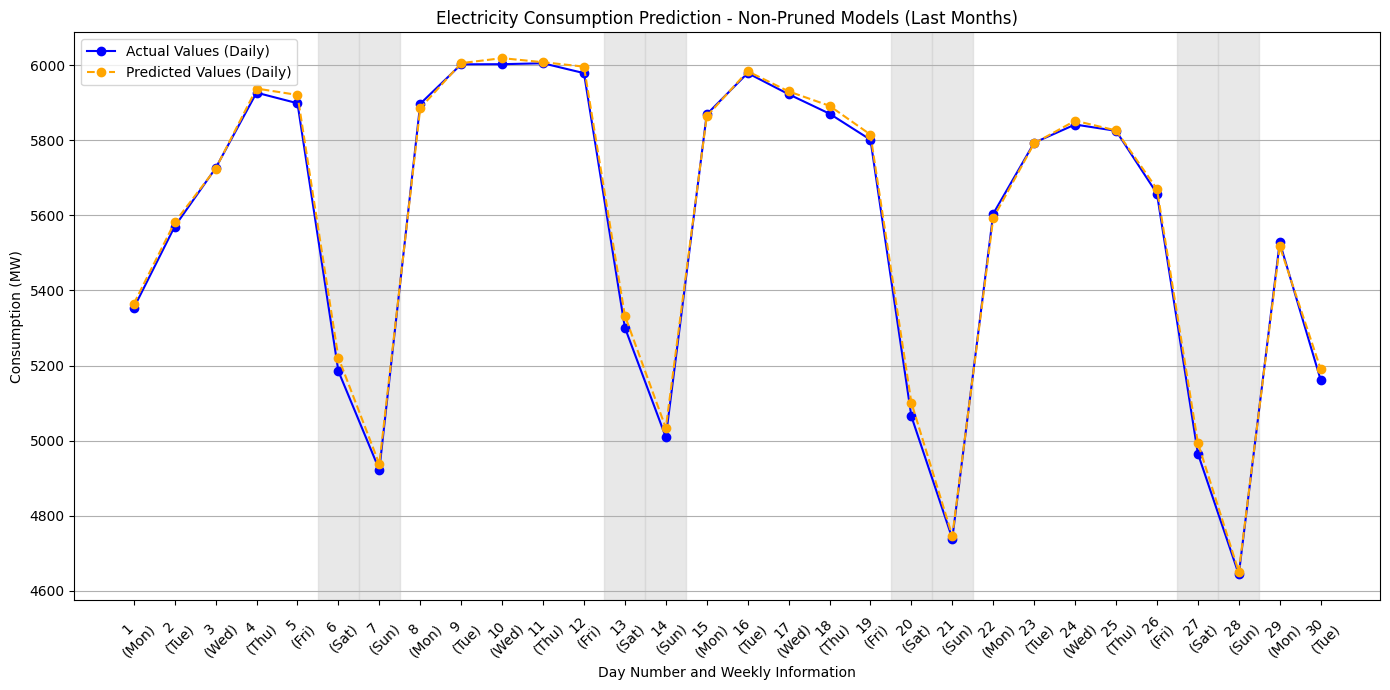

In [ ]:
# 5.
# Rescale test data on a daily basis
test_dates = data.index[-len(y_test_rescaled):]  # Test data dates
daily_test = pd.DataFrame({
    'date': test_dates,
    'true_value': y_test_rescaled.flatten(),
    'non_pruned_predicted_value': non_pruned_predicted_rescaled.flatten()
}).set_index('date')

# Calculate daily averages
daily_test_grouped = daily_test.resample('D').mean()

# **Weekly Subheading and Weekday/Weekend Distinction**
# Take the last month's daily data
daily_test_grouped_last_month = daily_test_grouped.loc[daily_test_grouped.index[-30:]]

# Generate day numbers
day_numbers = range(1, len(daily_test_grouped_last_month) + 1)

# Identify weekdays and weekends
dates = daily_test_grouped_last_month.index
weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
week_labels = [weekday_labels[date.weekday()] for date in dates]

# Plot the graph
plt.figure(figsize=(14, 7))

# Actual values
plt.plot(
    day_numbers,
    daily_test_grouped_last_month['true_value'],
    'o-',
    label='Actual Values (Daily)',
    color='blue'
)

# Predicted values
plt.plot(
    day_numbers,
    daily_test_grouped_last_month['non_pruned_predicted_value'],
    'o--',
    label='Predicted Values (Daily)',
    color='orange'
)

# Weekday/weekend color distinction
for i, (day_num, week_day) in enumerate(zip(day_numbers, week_labels)):
    if week_day in ['Sat', 'Sun']:  # Weekend
        plt.axvspan(day_num - 0.5, day_num + 0.5, color='lightgrey', alpha=0.5)

# Adjust axis
plt.title('Electricity Consumption Prediction - Non-Pruned Models (Last Months)')
plt.xlabel('Day Number and Weekly Information')
plt.ylabel('Consumption (MW)')
plt.xticks(day_numbers, [f"{num}\n({lbl})" for num, lbl in zip(day_numbers, week_labels)], rotation=45)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

# Show the graph
plt.show()

In [ ]:
# 6. **Define model architecture for pruned model**
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.20,
        final_sparsity=0.80,
        begin_step=0,
        end_step=1000
    )
}

pruned_lstm = tfmot.sparsity.keras.prune_low_magnitude(
    tf.keras.layers.LSTM(50, activation='relu'), **pruning_params
)

lstm_output = pruned_lstm(inputs)
dense_output = tf.keras.layers.Dense(1)(lstm_output)
pruned_model = tf.keras.Model(inputs=inputs, outputs=dense_output)

# Compile pruned model
pruned_model.compile(optimizer='adam', loss='mse')

# Train pruned model
logdir = tempfile.mkdtemp()
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tf.keras.callbacks.TensorBoard(log_dir=logdir)
]

pruned_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), callbacks=callbacks)

# Strip pruning wrappers for inference
final_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

# Evaluate pruned model
pruned_predicted = final_model.predict(X_test)
pruned_predicted_rescaled = scaler.inverse_transform(pruned_predicted)

Epoch 1/20
2517/2517 [==============================] - 32s 11ms/step - loss: 0.0057 - val_loss: 0.0012
Epoch 2/20
2517/2517 [==============================] - 26s 10ms/step - loss: 0.0013 - val_loss: 9.5332e-04
Epoch 3/20
2517/2517 [==============================] - 27s 11ms/step - loss: 0.0011 - val_loss: 8.8532e-04
Epoch 4/20
2517/2517 [==============================] - 27s 11ms/step - loss: 9.5683e-04 - val_loss: 9.2275e-04
Epoch 5/20
2517/2517 [==============================] - 27s 11ms/step - loss: 8.8172e-04 - val_loss: 0.0010
Epoch 6/20
2517/2517 [==============================] - 28s 11ms/step - loss: 8.5710e-04 - val_loss: 6.8944e-04
Epoch 7/20
2517/2517 [==============================] - 27s 11ms/step - loss: 8.1622e-04 - val_loss: 7.3121e-04
Epoch 8/20
2517/2517 [==============================] - 27s 11ms/step - loss: 7.9399e-04 - val_loss: 6.3889e-04
Epoch 9/20
2517/2517 [==============================] - 29s 12ms/step - loss: 7.8674e-04 - val_loss: 6.3767e-04
Epoch 10/20


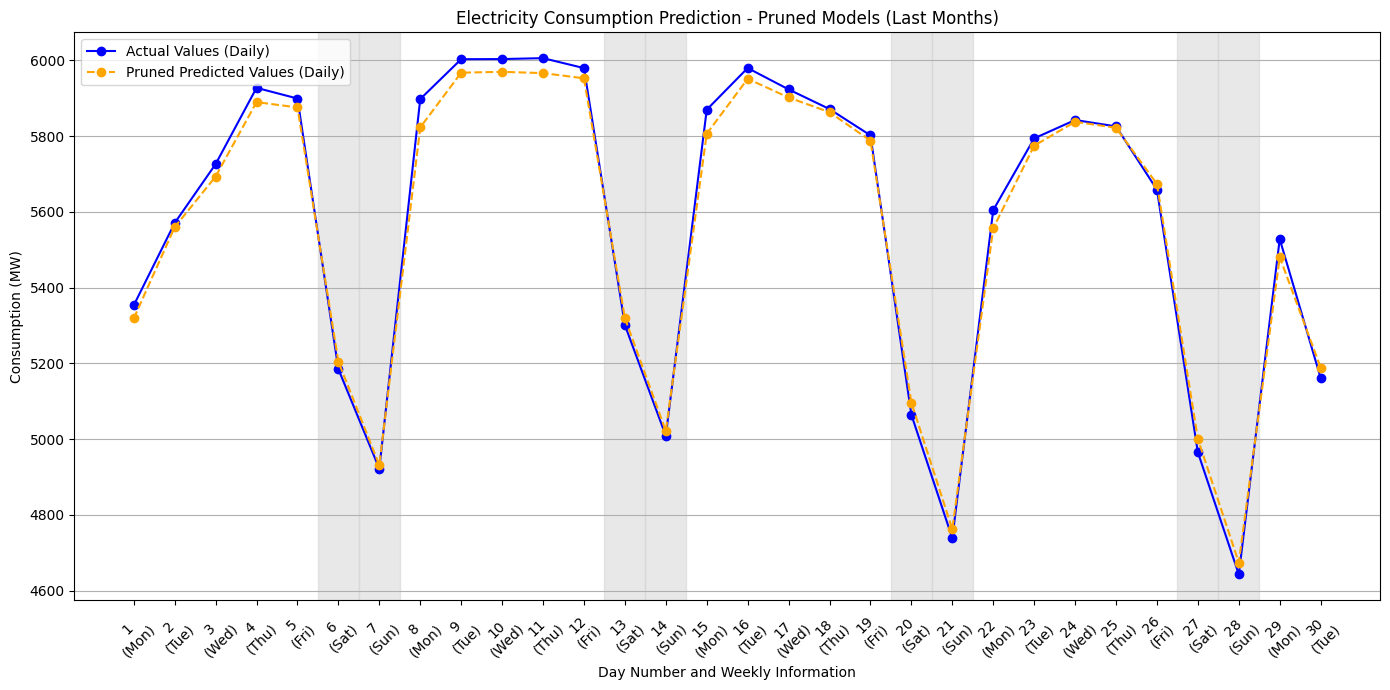

In [ ]:
# 7.
# Rescale test data on a daily basis
test_dates = data.index[-len(y_test_rescaled):]  # Test data dates
daily_test = pd.DataFrame({
    'date': test_dates,
    'true_value': y_test_rescaled.flatten(),
    'pruned_predicted_value': pruned_predicted_rescaled.flatten()
}).set_index('date')

# Calculate daily averages
daily_test_grouped = daily_test.resample('D').mean()

# **Weekly Subheading and Weekday/Weekend Distinction (pruned model)**
daily_test_grouped_last_month = daily_test_grouped.loc[daily_test_grouped.index[-30:]]

# Generate day numbers
day_numbers = range(1, len(daily_test_grouped_last_month) + 1)

# Weekday/weekend distinctions
dates = daily_test_grouped_last_month.index
week_labels = [weekday_labels[date.weekday()] for date in dates]

# Plot the graph
plt.figure(figsize=(14, 7))

# Actual values
plt.plot(
    day_numbers,
    daily_test_grouped_last_month['true_value'],
    'o-',
    label='Actual Values (Daily)',
    color='blue'
)

# Pruned predicted values
plt.plot(
    day_numbers,
    daily_test_grouped_last_month['pruned_predicted_value'],
    'o--',
    label='Pruned Predicted Values (Daily)',
    color='orange'
)

# Weekday/weekend color distinction
for i, (day_num, week_day) in enumerate(zip(day_numbers, week_labels)):
    if week_day in ['Sat', 'Sun']:  # Weekend
        plt.axvspan(day_num - 0.5, day_num + 0.5, color='lightgrey', alpha=0.5)

# Adjust axis
plt.title('Electricity Consumption Prediction - Pruned Models (Last Months)')
plt.xlabel('Day Number and Weekly Information')
plt.ylabel('Consumption (MW)')
plt.xticks(day_numbers, [f"{num}\n({lbl})" for num, lbl in zip(day_numbers, week_labels)], rotation=45)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

# Show the graph
plt.show()

In [ ]:
# 8. **Performance Analysis After Pruning**
pruned_mse = mean_squared_error(y_test_rescaled, pruned_predicted_rescaled)
pruned_mae = mean_absolute_error(y_test_rescaled, pruned_predicted_rescaled)

print(f"Mean Squared Error (MSE): {pruned_mse:.2f}")
print(f"Mean Absolute Error (MAE): {pruned_mae:.2f}")

# Display a comparison of performance metrics
performance_comparison = pd.DataFrame({
    'Model': ['Non-Pruned', 'Pruned'],
    'MSE': [non_pruned_mse, pruned_mse],
    'MAE': [non_pruned_mae, pruned_mae]
})

print(performance_comparison)

Mean Squared Error (MSE): 12535.77
Mean Absolute Error (MAE): 82.41
        Model           MSE        MAE
0  Non-Pruned   7519.903801  62.463461
1      Pruned  12535.773495  82.406755


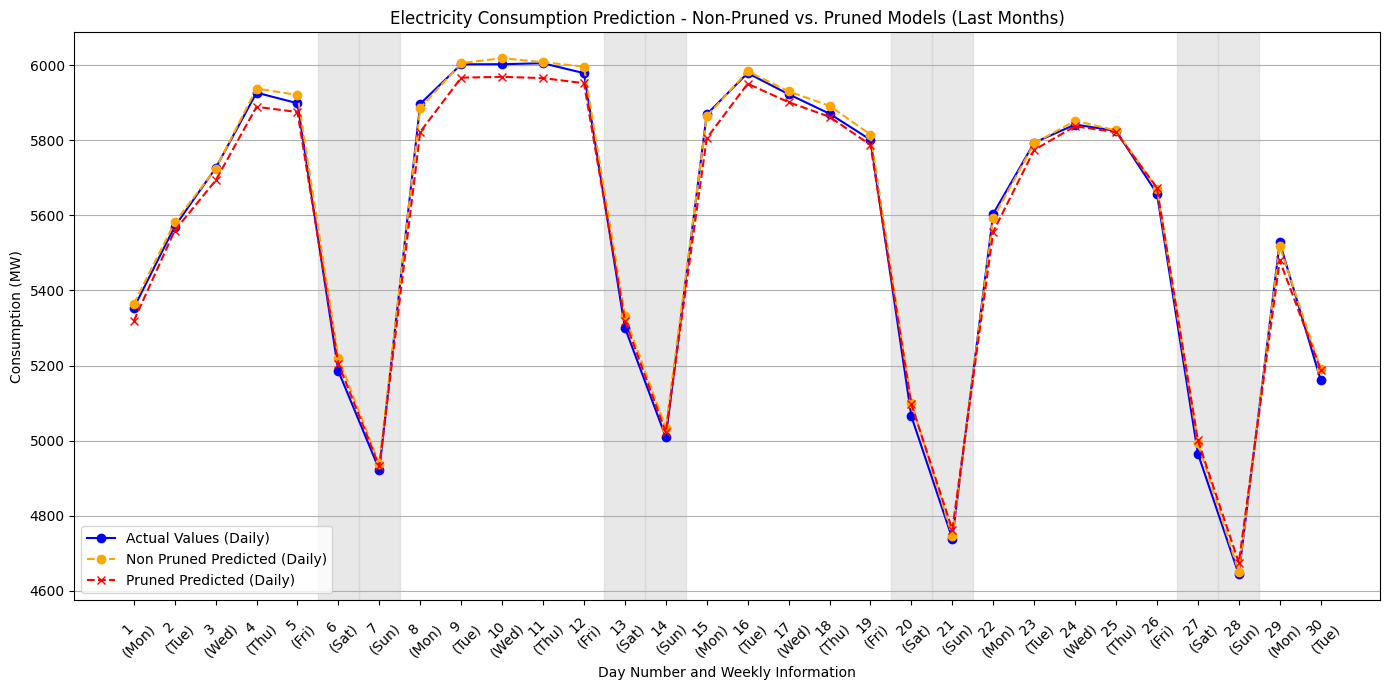

In [ ]:
# 9. Rescale test data and plot both models (non-pruned and pruned)
daily_test = pd.DataFrame({
    'date': test_dates,
    'true_value': y_test_rescaled.flatten(),
    'non_pruned_predicted_value': non_pruned_predicted_rescaled.flatten(),
    'pruned_predicted_value': pruned_predicted_rescaled.flatten()
}).set_index('date')

# Calculate daily averages and plot both models
daily_test_grouped = daily_test.resample('D').mean()

# **Weekly Subheading and Weekday/Weekend Distinction (pruned model)**
daily_test_grouped_last_month = daily_test_grouped.loc[daily_test_grouped.index[-30:]]

# Generate day numbers
day_numbers = range(1, len(daily_test_grouped_last_month) + 1)

# Weekday/weekend distinctions
dates = daily_test_grouped_last_month.index
week_labels = [weekday_labels[date.weekday()] for date in dates]

# Final comparisons of non-pruned vs. pruned models
plt.figure(figsize=(14, 7))

plt.plot(
    day_numbers,
    daily_test_grouped_last_month['true_value'],
    'o-',
    label='Actual Values (Daily)',
    color='blue'
)

plt.plot(
    day_numbers,
    daily_test_grouped_last_month['non_pruned_predicted_value'],
    'o--',
    label='Non Pruned Predicted (Daily)',
    color='orange'
)

plt.plot(
    day_numbers,
    daily_test_grouped_last_month['pruned_predicted_value'],
    'x--',
    label='Pruned Predicted (Daily)',
    color='red'
)
# Weekday/weekend distinction
for i, (day_num, week_day) in enumerate(zip(day_numbers, week_labels)):
    if week_day in ['Sat', 'Sun']:  # Weekend
        plt.axvspan(day_num - 0.5, day_num + 0.5, color='lightgrey', alpha=0.5)

# Adjust axis
plt.title('Electricity Consumption Prediction - Non-Pruned vs. Pruned Models (Last Months)')
plt.xlabel('Day Number and Weekly Information')
plt.ylabel('Consumption (MW)')
plt.xticks(day_numbers, [f"{num}\n({lbl})" for num, lbl in zip(day_numbers, week_labels)], rotation=45)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()

# Show the graph
plt.show()

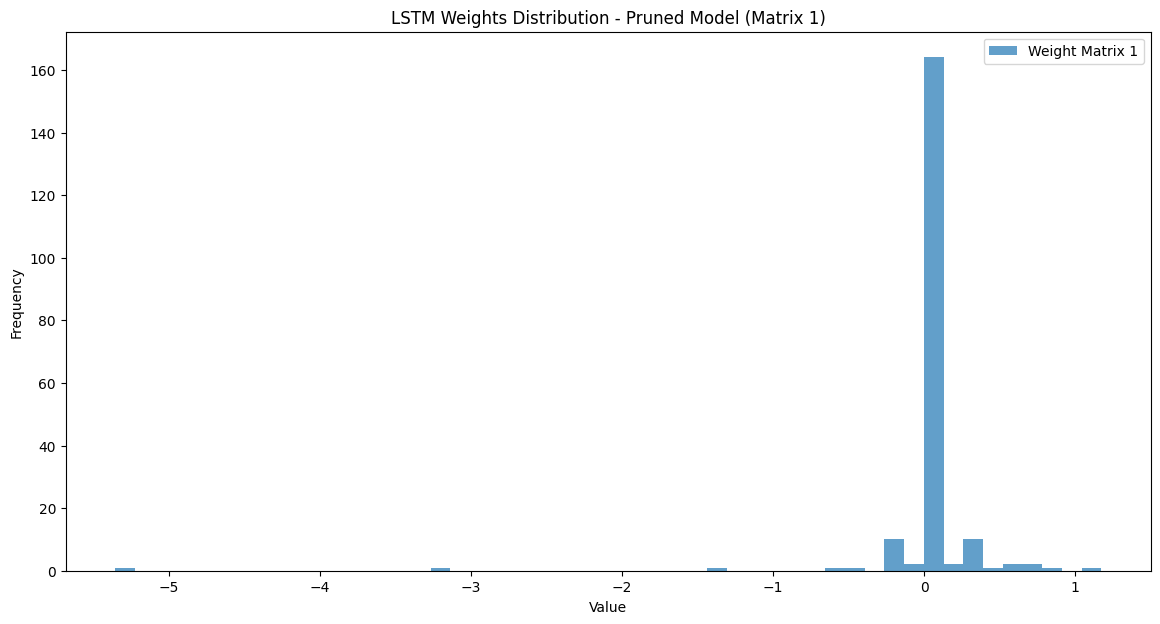

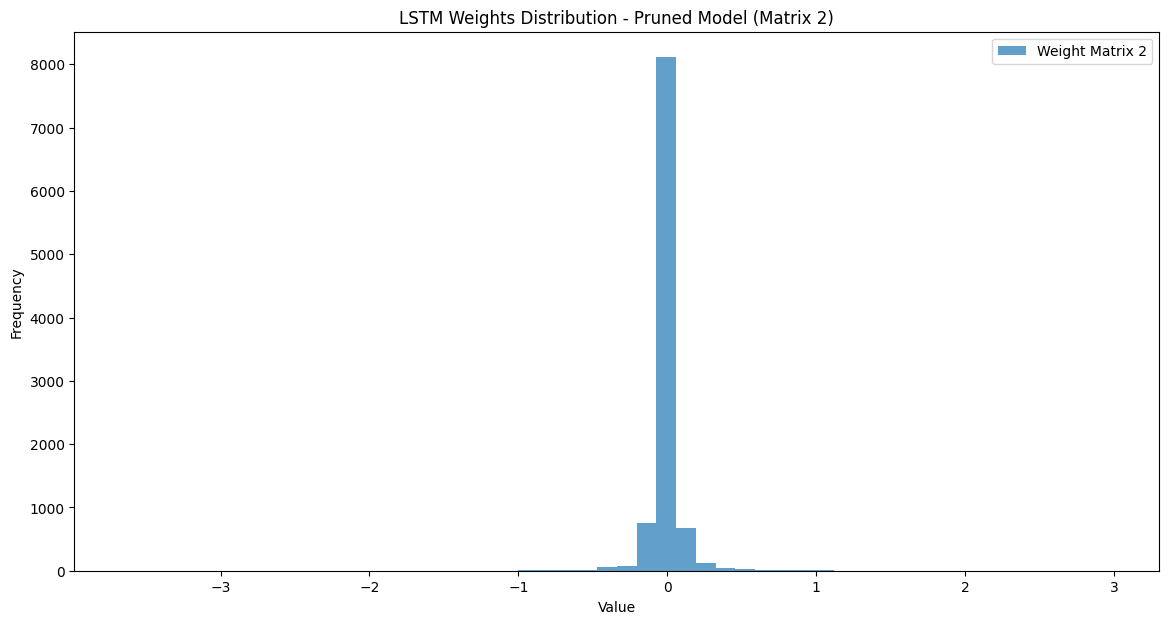

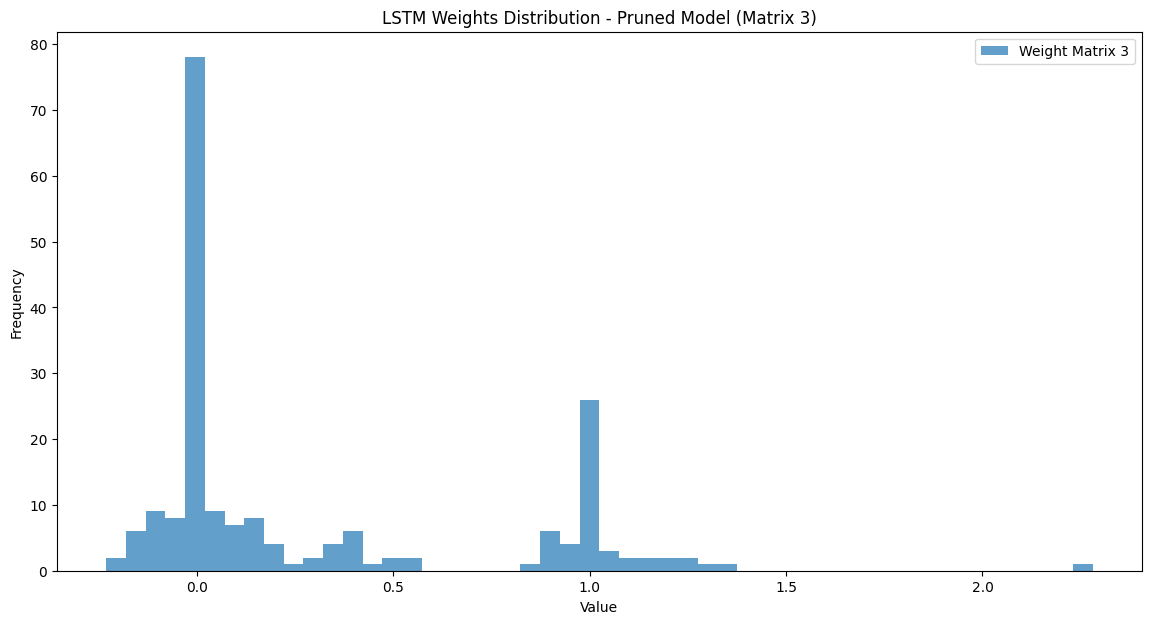

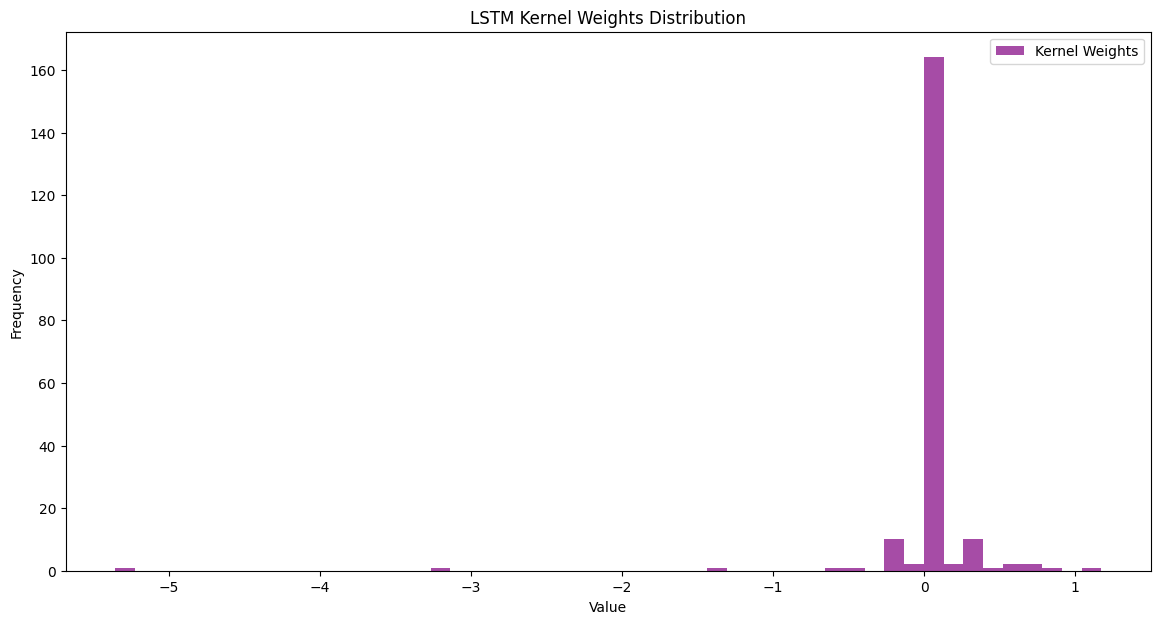

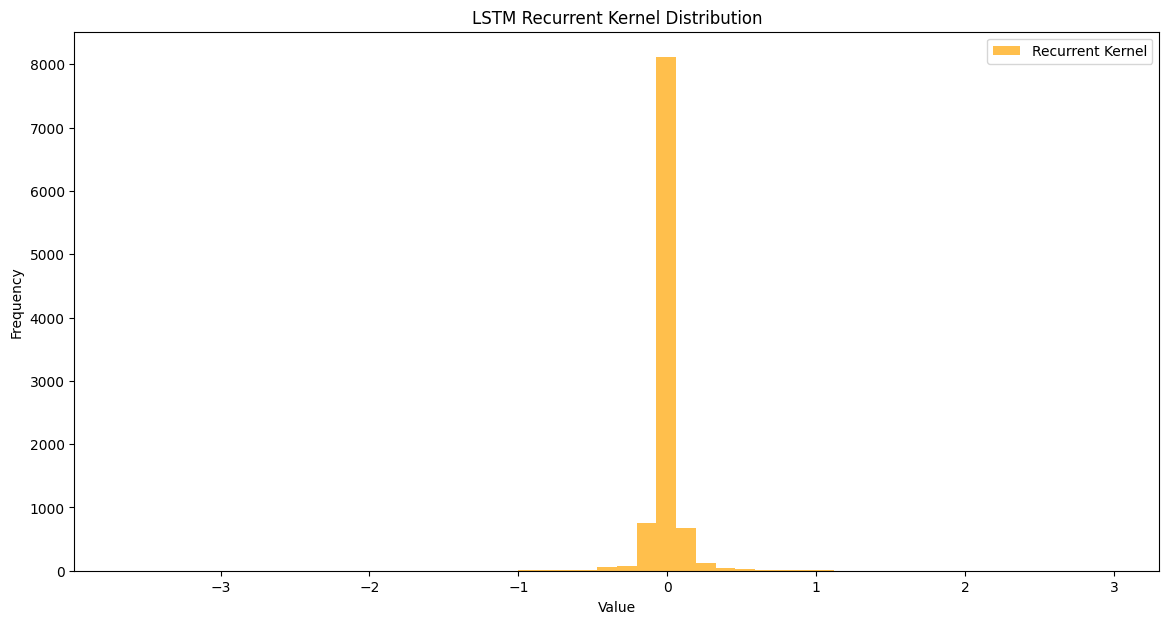

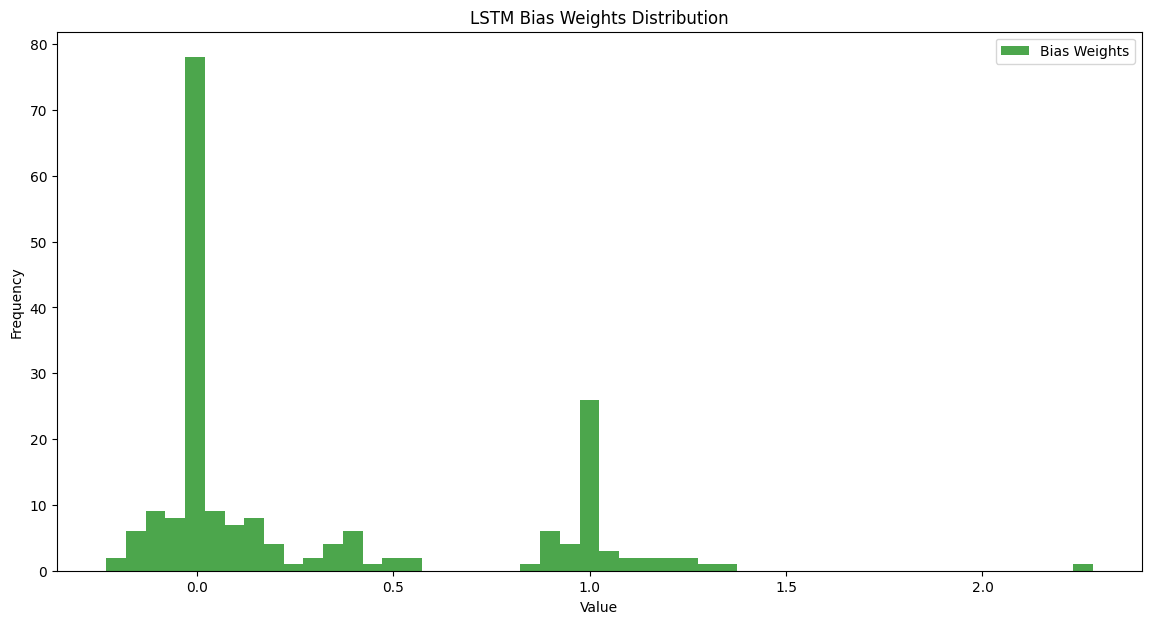

In [ ]:
# 10. Visualize pruned model weights
for layer in final_model.layers:
    if isinstance(layer, tf.keras.layers.LSTM):
        weights = layer.get_weights()
        for i, weight_matrix in enumerate(weights):
            plt.figure(figsize=(14, 7))
            plt.hist(weight_matrix.flatten(), bins=50, alpha=0.7, label=f'Weight Matrix {i+1}')
            plt.title(f'LSTM Weights Distribution - Pruned Model (Matrix {i+1})')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.legend()
            plt.show()

# Visualize pruned model weights for kernel, recurrent_kernel, and biases
for layer in final_model.layers:
    if isinstance(layer, tf.keras.layers.LSTM):
        # Get all weights of the LSTM layer
        all_weights = layer.get_weights()

        # Assuming the order is: kernel, recurrent_kernel, bias
        kernel = all_weights[0]
        recurrent_kernel = all_weights[1]
        bias = all_weights[2]

        plt.figure(figsize=(14, 7))
        plt.hist(kernel.flatten(), bins=50, color='purple', alpha=0.7, label='Kernel Weights')
        plt.title('LSTM Kernel Weights Distribution')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

        plt.figure(figsize=(14, 7))
        plt.hist(recurrent_kernel.flatten(), bins=50, color='orange', alpha=0.7, label='Recurrent Kernel')
        plt.title('LSTM Recurrent Kernel Distribution')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

        plt.figure(figsize=(14, 7))
        plt.hist(bias.flatten(), bins=50, color='green', alpha=0.7, label='Bias Weights')
        plt.title('LSTM Bias Weights Distribution')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()